In [ ]:
# Step 1: Import necessary libraries
from google.colab import files
import zipfile
import os



# Step 4: Create a directory to extract dataset
extract_path = "/content/dataset"
os.makedirs(extract_path, exist_ok=True)

# Step 5: Unzip the dataset
with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Dataset extracted to: {extract_path}")

# Step 6: (Optional) Check extracted folder structure
!ls -R /content/dataset


✅ Dataset extracted to: /content/dataset
/content/dataset:
Data

/content/dataset/Data:
glioma_tumor  meningioma_tumor	normal	pituitary_tumor

/content/dataset/Data/glioma_tumor:
G_100.jpg  G_217.jpg  G_333.jpg  G_44.jpg   G_566.jpg  G_682.jpg  G_799.jpg
G_101.jpg  G_218.jpg  G_334.jpg  G_450.jpg  G_567.jpg  G_683.jpg  G_79.jpg
G_102.jpg  G_219.jpg  G_335.jpg  G_451.jpg  G_568.jpg  G_684.jpg  G_7.jpg
G_103.jpg  G_21.jpg   G_336.jpg  G_452.jpg  G_569.jpg  G_685.jpg  G_800.jpg
G_104.jpg  G_220.jpg  G_337.jpg  G_453.jpg  G_56.jpg   G_686.jpg  G_801.jpg
G_105.jpg  G_221.jpg  G_338.jpg  G_454.jpg  G_570.jpg  G_687.jpg  G_802.jpg
G_106.jpg  G_222.jpg  G_339.jpg  G_455.jpg  G_571.jpg  G_688.jpg  G_803.jpg
G_107.jpg  G_223.jpg  G_33.jpg	 G_456.jpg  G_572.jpg  G_689.jpg  G_804.jpg
G_108.jpg  G_224.jpg  G_340.jpg  G_457.jpg  G_573.jpg  G_68.jpg   G_805.jpg
G_109.jpg  G_225.jpg  G_341.jpg  G_458.jpg  G_574.jpg  G_690.jpg  G_806.jpg
G_10.jpg   G_226.jpg  G_342.jpg  G_459.jpg  G_575.jpg  G_691.jpg 

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
thomasdubail_brain_tumors_256x256_path = kagglehub.dataset_download('thomasdubail/brain-tumors-256x256')

print('Data source import complete.')


100%|██████████| 59.4M/59.4M [00:00<00:00, 174MB/s]

Extracting files...


Data source import complete.


In [ ]:
# Core dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# For pretrained models and modern CNN architectures
!pip install timm

# For metrics and model evaluation
!pip install torchmetrics scikit-learn

# For data manipulation and scientific computing
!pip install numpy==1.22.4 scipy==1.9.3

# For visualization and progress tracking
!pip install matplotlib tqdm


Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached numpy-1.22.4.zip (11.5 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


# Imports

In [ ]:
import numpy as np
import random
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchmetrics.classification import AUROC, Accuracy
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve,\
                            average_precision_score, accuracy_score, f1_score,\
                            precision_score, recall_score, classification_report
import os
from sklearn.model_selection import train_test_split
import shutil
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot as plt
import timm

# Global settings

In [ ]:
OPTIM_PARAMS = {"lr":1e-5}
OPTIM = torch.optim.AdamW
CRITERIUM = torch.nn.CrossEntropyLoss
BATCH_SIZE = 16
IMAGE_SIZE = 256
N_EPOCHS = 50
PATIENCE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2 if DEVICE=='cuda' else 4 # fixed by kaggle notebook
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Data split load

In [ ]:
%%capture
!cp -r /kaggle/input/brain-tumors-256x256/Data /content/data

In [ ]:
data_dir = '/content/dataset/Data'
output_dir = '//content/dataset/'

train_percent = 0.7
val_percent = 0.1
test_percent = 0.2

for root, dirs, files in os.walk(data_dir):
    if len(files) > 0:
        train_files, temp_files = train_test_split(files, test_size=(1 - train_percent), random_state=SEED)
        val_files, test_files = train_test_split(temp_files, test_size=(test_percent / (test_percent + val_percent)), random_state=SEED)
        for split_name,files in zip(["train","val","test"],[train_files,val_files,test_files]):
            new_output_dir = os.path.join(output_dir, split_name, os.path.relpath(root, data_dir))
            os.makedirs(new_output_dir, exist_ok=True)
            #print(new_output_dir)
            for file in files:
                src = os.path.join(root, file)
                dst = os.path.join(new_output_dir, file)
                shutil.move(src, dst)


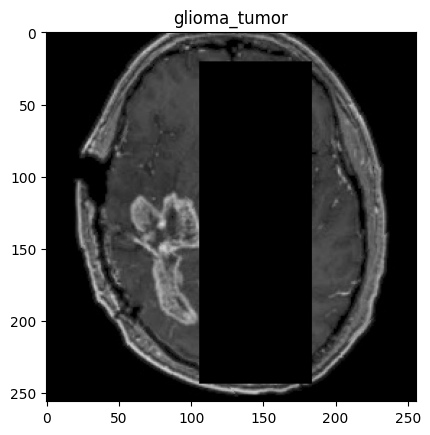

In [ ]:
transform_train = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(5,translate=[0,.1],scale=[.9,1.1]),
                                      transforms.ToTensor(),
                                      transforms.RandomErasing(),
                                     ])

transform_val = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                    transforms.ToTensor(),
                                   ])

train = ImageFolder("/content/dataset/train",
                    transform=transform_train,
                   )

val = ImageFolder("/content/dataset/val",
                    transform=transform_val,
                   )

test = ImageFolder("/content/dataset/test",
                    transform=transform_val,
                   )

class_names = train.classes

plt.imshow(train[0][0].transpose(0,2).transpose(1,0))
plt.title(train.classes[train[0][1]])
plt.show()

In [ ]:
# loaders :
train_loader = DataLoader(train,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True,drop_last=True)
val_loader = DataLoader(val,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False,drop_last=False)
test_loader = DataLoader(test,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False,drop_last=False)

# Model

In [ ]:
model = timm.create_model('swinv2_tiny_window8_256.ms_in1k', pretrained=True)
model.head.fc = torch.nn.Linear(in_features=model.head.fc.in_features,out_features=4)
model(torch.randn((BATCH_SIZE,3,IMAGE_SIZE,IMAGE_SIZE))).shape

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

torch.Size([16, 4])

# Train

In [ ]:
model.to(DEVICE)

optimizer = OPTIM(model.parameters(),**OPTIM_PARAMS)
criterium = CRITERIUM()

best_model = deepcopy(model)
best_acc = 0
patience = 0

for epoch in range(N_EPOCHS):
    train_loss = 0
    train_total = 0
    model.train()
    for x,y in tqdm(train_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        output = model(x)
        loss = criterium(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_total += x.size(0)
    train_loss /= train_total

    val_loss = 0
    val_total = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for x,y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            output = model(x)
            loss = criterium(output,y)
            val_loss += loss.item() * x.size(0)
            val_total += x.size(0)
            val_acc += torch.sum(torch.argmax(output,dim=-1)==y).item()
    val_loss /= val_total
    val_acc /= val_total


    # save
    if val_acc > best_acc :
        best_acc = val_acc
        best_model = deepcopy(model)
        patience = 0
    else :
        patience += 1

    print("Epoch {} : train loss {:.4f} | val loss {:.4f} | val Acc {:.3f}".format(epoch,
                                                                                   train_loss,
                                                                                   val_loss,
                                                                                   val_acc))

    # earlystopping
    if patience >= PATIENCE :
        break

100%|██████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 0 : train loss 0.8869 | val loss 0.5730 | val Acc 0.773


100%|██████████| 135/135 [00:38<00:00,  3.52it/s]


Epoch 1 : train loss 0.4243 | val loss 0.3267 | val Acc 0.896


100%|██████████| 135/135 [00:39<00:00,  3.42it/s]


Epoch 2 : train loss 0.3348 | val loss 0.2563 | val Acc 0.906


100%|██████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 3 : train loss 0.2681 | val loss 0.2363 | val Acc 0.922


100%|██████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 4 : train loss 0.2293 | val loss 0.2251 | val Acc 0.929


100%|██████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 5 : train loss 0.2023 | val loss 0.2000 | val Acc 0.929


100%|██████████| 135/135 [00:40<00:00,  3.37it/s]


Epoch 6 : train loss 0.2045 | val loss 0.1673 | val Acc 0.961


100%|██████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 7 : train loss 0.1567 | val loss 0.2108 | val Acc 0.935


100%|██████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 8 : train loss 0.1568 | val loss 0.1279 | val Acc 0.955


 61%|██████▏   | 83/135 [00:24<00:15,  3.35it/s]


KeyboardInterrupt: 

# Graphs

In [ ]:
y_true, y_pred = [], []
model = best_model
model.eval()
with torch.no_grad():
    for x,y in tqdm(test_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        output = model(x).softmax(dim=-1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(output.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

100%|██████████| 39/39 [00:04<00:00,  9.04it/s]


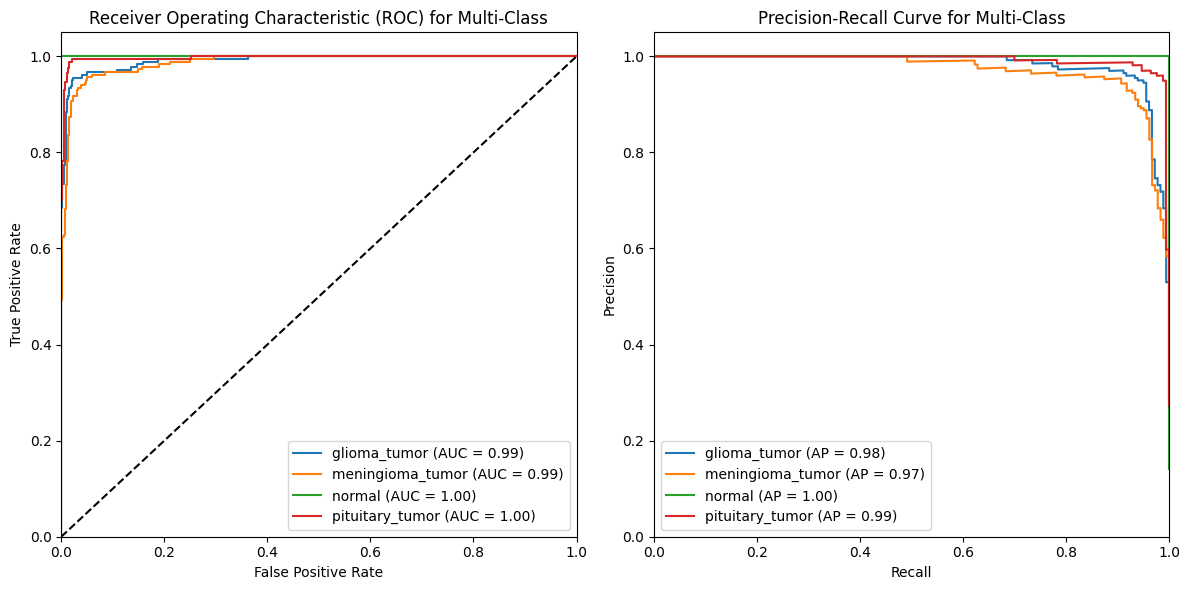

In [ ]:
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])

plt.figure(figsize=(12, 6))
for i in range(n_classes):
    plt.subplot(1, 2, 1)
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')

for i in range(n_classes):
    plt.subplot(1, 2, 2)
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {average_precision[i]:0.2f})')

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Metrics

In [ ]:
y_pred_labels = y_pred.argmax(axis=1)
accuracy = accuracy_score(y_true, y_pred_labels)
report = classification_report(y_true, y_pred_labels, target_names=class_names,zero_division=0)
print(report)
print(f'Accuracy: {accuracy:.2f}')

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.94      0.95       181
meningioma_tumor       0.93      0.92      0.93       183
          normal       0.97      1.00      0.98        88
 pituitary_tumor       0.97      0.98      0.97       170

        accuracy                           0.95       622
       macro avg       0.96      0.96      0.96       622
    weighted avg       0.95      0.95      0.95       622

Accuracy: 0.95


In [ ]:
import torch
import os

# Create a directory to store models
os.makedirs("saved_models", exist_ok=True)

# Path to save
model_path = "saved_models/best_model.pth"

# Save only the model weights
torch.save(model.state_dict(), model_path)

print(f"✅ Model weights saved at: {model_path}")


✅ Model weights saved at: saved_models/best_model.pth


In [ ]:
pip install Image


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 93.9 MB/s eta 0:00:00
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=63e6d543c78323e8cb06273ea91c2ae6fa832bafeadae6c4549c21f10fbece35
  Stored in directory: /root/.cache/pip/wheels/58/30/d8/3212cd83eeeeee0a1f0c7b9b7bd0674a2b9f09342870473a2a
Successfully built Image


🧠 Using device: cuda
📁 Please upload an image for prediction:


Saving P_349.jpg to P_349.jpg
✅ Loaded 4 class names: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
✅ Model loaded successfully!


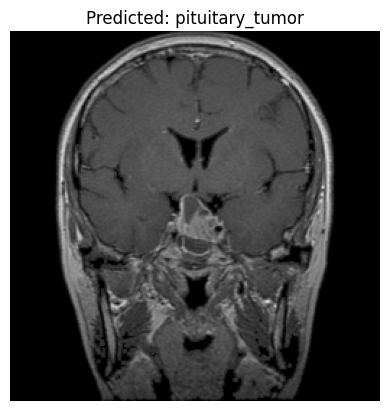

✅ Predicted class: pituitary_tumor


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# ----- 1️⃣ Device setup -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🧠 Using device: {device}")

# ----- 2️⃣ Upload an image -----
print("📁 Please upload an image for prediction:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

from torchvision.datasets import ImageFolder

# Point this to your training data directory
train_dir = "/content/dataset/train"
train_dataset = ImageFolder(train_dir)
class_names = train_dataset.classes

print(f"✅ Loaded {len(class_names)} class names: {class_names}")


# ----- 3️⃣ Load model weights (plain state_dict) -----
model_path = "saved_models/best_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print("✅ Model loaded successfully!")

# ----- 4️⃣ Define your class names manually (since plain .pth doesn’t store them) -----
#class_names = ['Pituitary', 'Normal', 'Meningioma','Glioma']  # 👈 Replace with your dataset’s actual labels

# ----- 5️⃣ Image preprocessing -----
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # ✅ must match training size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# ----- 6️⃣ Make prediction -----
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()

pred_label = class_names[pred_idx]

# ----- 7️⃣ Display result -----
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {pred_label}")
plt.show()

print(f"✅ Predicted class: {pred_label}")
